In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("data.csv")
df.head()

,Order No,Order Date,Customer Name,Address,City,State,Customer Type,Account Manager,Order Priority,Product Name,...,Cost Price,Retail Price,Profit Margin,Order Quantity,Sub Total,Discount %,Discount $,Order Total,Shipping Cost,Total
0,4293-1,02-09-2014,Vivek Sundaresam,"152 Bunnerong Road,Eastgardens",Sydney,NSW,Small Business,Tina Carlton,Critical,UGen Ultra Professional Cordless Optical Suite,...,$156.50,$300.97,$144.47,23.0,"$4,533.52",2%,$194.83,"$4,757.22",$7.18,"$4,291.55"
1,5001-1,24-10-2015,Shahid Hopkins,"438 Victoria Avenue,Chatswood",Sydney,NSW,Corporate,Natasha Song,Medium,Bagged Rubber Bands,...,$0.24,$1.26,$1.02,8.0,$45.20,3%,$0.00,$45.90,$0.70,$46.91
2,5004-1,13-03-2014,Dennis Pardue,"412 Brunswick St,Fitzroy",Melbourne,VIC,Consumer,Connor Betts,Not Specified,TechSavi Cordless Navigator Duo,...,$42.11,$80.98,$38.87,45.0,$873.32,4%,$72.23,$837.57,$7.18,$82.58
3,5009-1,18-02-2013,Sean Wendt,"145 Ramsay St,Haberfield",Sydney,NSW,Small Business,Phoebe Gour,Critical,Artisan Printable Repositionable Plastic Tabs,...,$5.33,$8.60,$3.27,16.0,$73.52,1%,$4.35,$740.67,$6.19,$730.92
4,5010-1,13-09-2014,Christina Vanderzanden,"188 Pitt Street,Sydney",Sydney,NSW,Small Business,Tina Carlton,Not Specified,Pizazz Drawing Pencil Set,...,$1.53,$2.78,$1.25,49.0,$138.46,7%,$5.95,$123.77,$1.34,$125.97


In [3]:
column_names = df.columns
column_names

Index(['Order No', 'Order Date', 'Customer Name', 'Address', 'City', 'State',
       'Customer Type', 'Account Manager', 'Order Priority', 'Product Name',
       'Product Category', 'Product Container', 'Ship Mode', 'Ship Date',
       'Cost Price', 'Retail Price', 'Profit Margin', 'Order Quantity',
       'Sub Total', 'Discount %', 'Discount $', 'Order Total', 'Shipping Cost',
       'Total'],
      dtype='object')

In [4]:
first_row = df.iloc[0].values
first_row

array(['4293-1', '02-09-2014', 'Vivek Sundaresam',
       '152 Bunnerong Road,Eastgardens', 'Sydney', 'NSW',
       'Small Business', 'Tina Carlton', 'Critical',
       'UGen Ultra Professional Cordless Optical Suite',
       'Office Supplies', 'Small Box', 'Regular Air', '04-09-2014',
       '$156.50', '$300.97', '$144.47', 23.0, '$4,533.52', '2%',
       '$194.83', '$4,757.22', '$7.18', '$4,291.55'], dtype=object)

In [5]:
currency_cols = ['Cost Price', 'Retail Price', 'Profit Margin', 
                 'Sub Total', 'Discount $', 'Order Total', 'Shipping Cost', 'Total']

for col in currency_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Convert Discount % to numeric
df['Discount %'] = df['Discount %'].replace('%', '', regex=True).astype(float)

# Convert dates
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d-%m-%Y')

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Order No             0
Order Date           0
Customer Name        0
Address              1
City                 0
State                0
Customer Type        0
Account Manager      0
Order Priority       0
Product Name         0
Product Category     0
Product Container    0
Ship Mode            0
Ship Date            0
Cost Price           0
Retail Price         0
Profit Margin        0
Order Quantity       1
Sub Total            0
Discount %           0
Discount $           0
Order Total          0
Shipping Cost        0
Total                0
dtype: int64


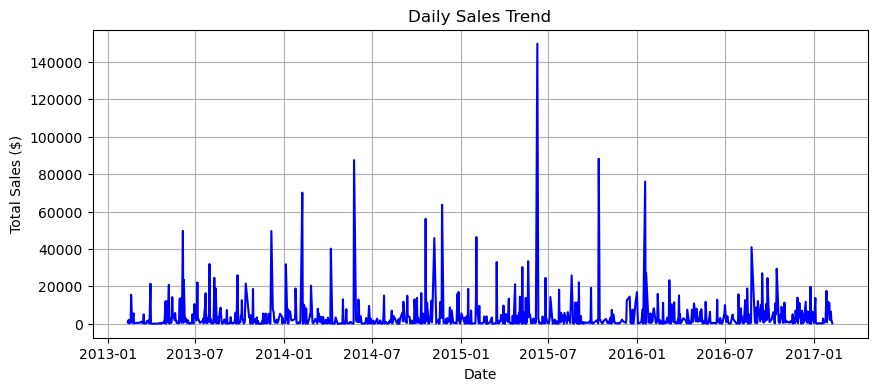

In [6]:
sales_trend = df.groupby('Order Date')['Total'].sum()

plt.figure(figsize=(10,4))
plt.plot(sales_trend, color='blue')
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales ($)")
plt.grid(True)
plt.show()

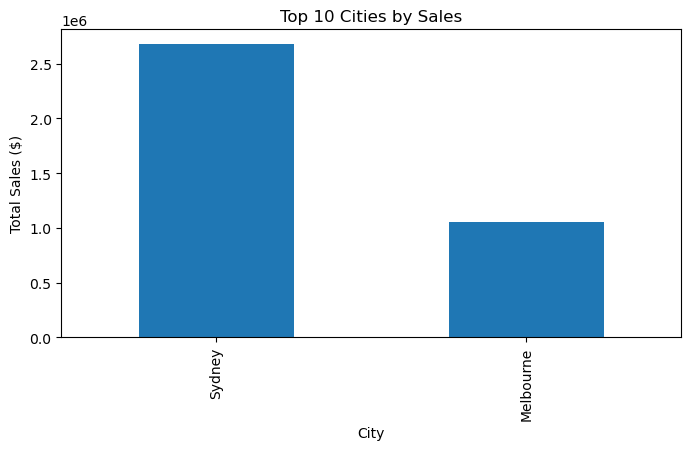

In [7]:
plt.figure(figsize=(8,4))
df.groupby('City')['Total'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Cities by Sales")
plt.ylabel("Total Sales ($)")
plt.show()

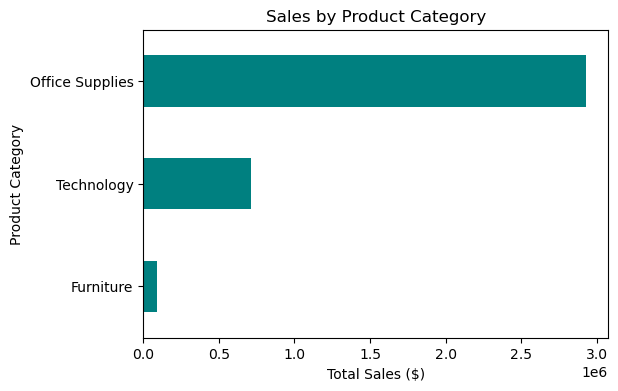

In [8]:
plt.figure(figsize=(6,4))
df.groupby('Product Category')['Total'].sum().sort_values().plot(kind='barh', color='teal')
plt.title("Sales by Product Category")
plt.xlabel("Total Sales ($)")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select features (excluding IDs, names, and addresses)
X = df[['Customer Type', 'Order Priority', 'Product Category',
        'Product Container', 'Ship Mode', 'Order Quantity', 'Discount %',
        'Shipping Cost', 'Cost Price', 'Retail Price', 'Profit Margin']]

y = df['Total']

# Convert categorical features using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

print("Missing values in features before training:\n", X.isnull().sum())

# Option 1 — Fill missing numeric values with column mean (recommended)
X = X.fillna(X.mean(numeric_only=True))

# Option 2 — Fill categorical columns with the most frequent value
for col in X.columns:
    if X[col].dtype == 'object':
        X[col].fillna(X[col].mode()[0], inplace=True)

# Ensure target has no NaN
y = y.fillna(y.mean())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
print("R² Score:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

Missing values in features before training:
 Order Quantity                      1
Discount %                          0
Shipping Cost                       0
Cost Price                          0
Retail Price                        0
Profit Margin                       0
Customer Type_Corporate             0
Customer Type_Home Office           0
Customer Type_Small Business        0
Order Priority_High                 0
Order Priority_Low                  0
Order Priority_Medium               0
Order Priority_Not Specified        0
Product Category_Office Supplies    0
Product Category_Technology         0
Product Container_Large Box         0
Product Container_Medium Box        0
Product Container_Small Box         0
Product Container_Small Pack        0
Product Container_Wrap Bag          0
Ship Mode_Express Air               0
Ship Mode_Regular Air               0
dtype: int64
R² Score: 0.361
MAE: 513.18


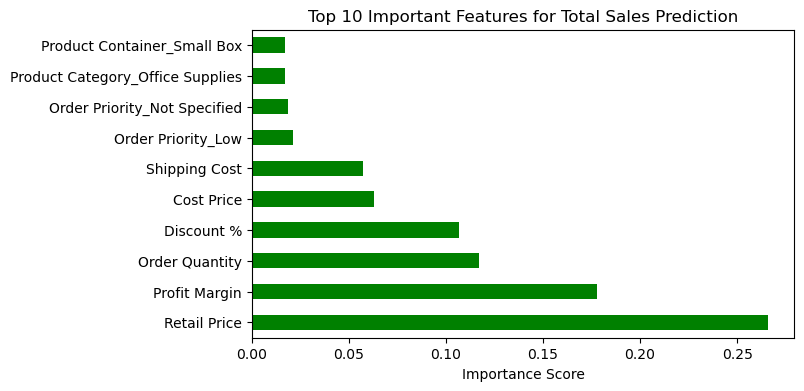

In [12]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(7,4))
feat_imp.plot(kind='barh', color='green')
plt.title("Top 10 Important Features for Total Sales Prediction")
plt.xlabel("Importance Score")
plt.show()

In [13]:
print("\n✅ Key Insights:")
print("1. Top selling city:", df.groupby('City')['Total'].sum().idxmax())
print("2. Top product category:", df.groupby('Product Category')['Total'].sum().idxmax())
print("3. Highest average profit margin category:", profit_cat.idxmax())
print("4. Model R² Score:", round(r2_score(y_test, y_pred), 3))
print("5. Most influential factor:", feat_imp.index[0])


✅ Key Insights:
1. Top selling city: Sydney
2. Top product category: Office Supplies
3. Highest average profit margin category: Technology
4. Model R² Score: 0.361
5. Most influential factor: Retail Price


In [14]:
df.groupby('Product Category')['Profit Margin'].mean()


Product Category
Furniture          12.701953
Office Supplies    17.682609
Technology         20.423208
Name: Profit Margin, dtype: float64

C:\Users\cavad\AppData\Local\Temp\ipykernel_35596\121663859.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Product Category', y='Profit', estimator='sum', ci=None, palette='viridis')


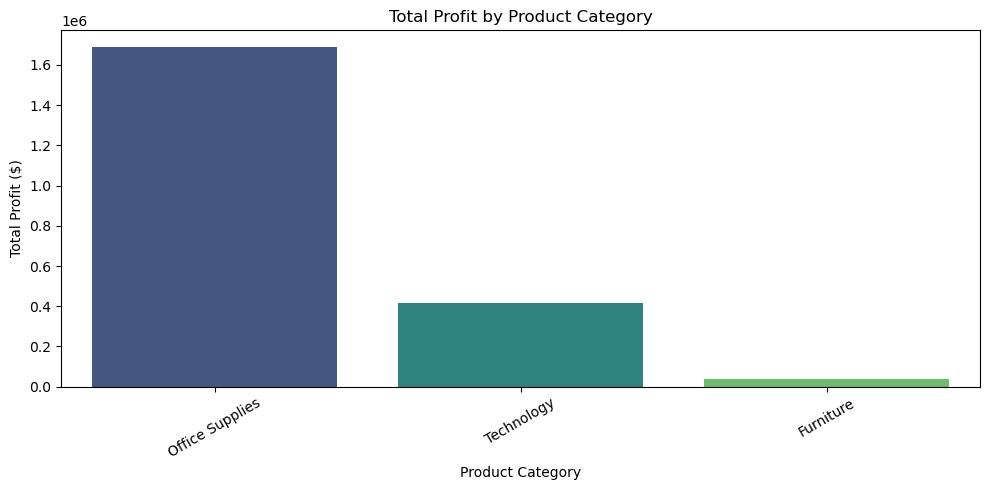

In [17]:
money_cols = ['Cost Price', 'Retail Price', 'Profit Margin', 'Sub Total',
              'Discount $', 'Order Total', 'Shipping Cost', 'Total']
for col in money_cols:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Compute profit per order
df['Profit'] = (df['Retail Price'] - df['Cost Price']) * df['Order Quantity'] - df['Discount $'] - df['Shipping Cost']

plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Product Category', y='Profit', estimator='sum', ci=None, palette='viridis')
plt.title("Total Profit by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Total Profit ($)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


C:\Users\cavad\AppData\Local\Temp\ipykernel_35596\2795236990.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Customer Type', y='Profit', estimator='sum', ci=None, palette='mako')


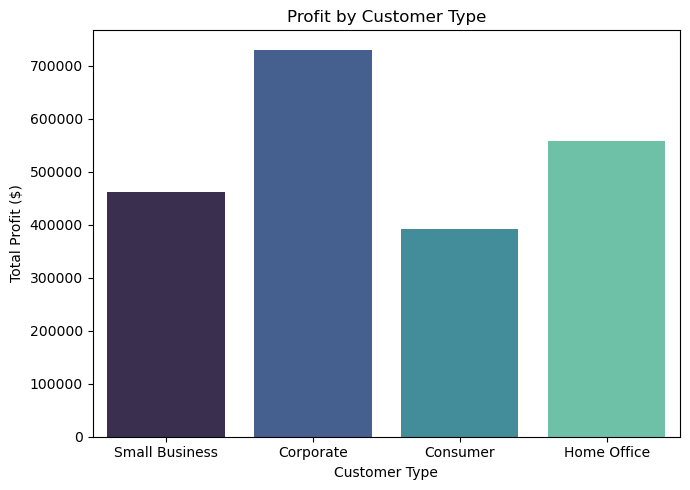

In [18]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x='Customer Type', y='Profit', estimator='sum', ci=None, palette='mako')
plt.title("Profit by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Total Profit ($)")
plt.tight_layout()
plt.show()

In [28]:
total_sales = df['Total'].sum()
total_profit = df['Profit'].sum()
avg_profit_margin = (total_profit / total_sales) * 100
top_category = df.groupby('Product Category')['Profit'].sum().idxmax()
top_customer = df.groupby('Customer Name')['Profit'].sum().idxmax()

print("---- Overall Insights ----")
print(f"Total Sales: ${total_sales:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Average Profit Margin: {avg_profit_margin:.2f}%")
print(f"Most Profitable Product Category: {top_category}")
print(f"Top Customer by Profit: {top_customer}")

---- Overall Insights ----
Total Sales: $3,731,536.40
Total Profit: $2,142,609.54
Average Profit Margin: 57.42%
Most Profitable Product Category: Office Supplies
Top Customer by Profit: Trudy Brown


In [29]:
category_profit = df.groupby('Product Category')['Profit'].agg(['sum', 'mean', 'count']).sort_values('sum', ascending=False)
print("\n---- Profit by Category ----")
print(category_profit)



---- Profit by Category ----
                         sum        mean  count
Product Category                               
Office Supplies   1687549.41  427.011490   3952
Technology         414582.51  471.652457    879
Furniture           40477.62  240.938214    168


In [31]:
shipping_impact = df.groupby('Ship Mode')[['Shipping Cost', 'Profit']].mean().sort_values('Profit', ascending=False)
print("\n---- Shipping Mode Impact ----")
print(shipping_impact)



---- Shipping Mode Impact ----
                Shipping Cost      Profit
Ship Mode                                
Delivery Truck       5.270085  445.308120
Regular Air          5.503553  435.749504
Express Air          5.247311  378.839784


In [32]:
monthly_profit = df.groupby('Month')['Profit'].sum()
best_month = monthly_profit.idxmax()
worst_month = monthly_profit.idxmin()

print("\n---- Monthly Performance ----")
print(monthly_profit)
print(f"\nBest Month: {best_month}, Worst Month: {worst_month}")



---- Monthly Performance ----
Month
2013-02     29907.26
2013-03     12651.01
2013-04     19346.80
2013-05     72544.20
2013-06     40376.40
2013-07    100241.69
2013-08     65081.05
2013-09     21163.61
2013-10     59038.08
2013-11     34424.17
2013-12     81418.35
2014-01     65902.07
2014-02     51751.27
2014-03     28500.15
2014-04     11113.61
2014-05     19612.96
2014-06     26393.51
2014-07     14206.49
2014-08     21761.74
2014-09     36201.38
2014-10     73887.60
2014-11     59891.50
2014-12     62125.97
2015-01     27338.08
2015-02     67470.63
2015-03     48518.74
2015-04     47279.88
2015-05     51179.68
2015-06     40139.68
2015-07     40458.49
2015-08     43501.14
2015-09     38642.14
2015-10     26423.87
2015-11     16716.08
2015-12     43622.34
2016-01     22912.74
2016-02     39613.57
2016-03     69402.30
2016-04     27307.50
2016-05     39755.43
2016-06     18470.71
2016-07     17877.86
2016-08     88738.23
2016-09     80896.80
2016-10    102665.83
2016-11     25052.

In [33]:
top5_products = df.groupby('Product Name')['Profit'].sum().nlargest(5)
bottom5_products = df.groupby('Product Name')['Profit'].sum().nsmallest(5)

print("\n---- Top 5 Products ----")
print(top5_products)
print("\n---- Bottom 5 Products ----")
print(bottom5_products)



---- Top 5 Products ----
Product Name
Cando PC940 Copier                                417643.79
HFX LaserJet 3310 Copier                          252847.60
Adesso Programmable 142-Key Keyboard              181288.06
Deluxe Rollaway Locking File with Drawer          172252.28
UGen Ultra Professional Cordless Optical Suite    169270.69
Name: Profit, dtype: float64

---- Bottom 5 Products ----
Product Name
HFX LaserJet 331 Colored Pencils   -1615.20
HFX 6S Scientific Calculator       -1254.15
UGen Ultra Profes                   -988.97
Artisan Lamy Binders                -352.97
UGen Ultra Eron Style Paps          -331.30
Name: Profit, dtype: float64
